# Preparing dataset

The pandas dataframe is translated into a NumPy array, and split into 70% training, 30% testing.
The shapes are

Training
- X: (4922, 18)
- y: (4922,)

Testing
- X_test: (2110, 18)
- y_test: (2110,)

In [132]:
# libraries and reading csv

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn import tree # for plotting tree
from sklearn.tree import DecisionTreeClassifier # for building tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV # for tuning hyperparameters
from sklearn import metrics # for displaying roc curve, and calculating TPR, FPR

import pickle # for saving scikit learn models

df = pd.read_csv('churn.csv') # (7032, 19)

All columns and their possible values

| column name | possible values | | column name | possible values | | column name | possible values |
|---|---|-|---|---|-|---|---|
| gender | 'Female', 'Male' | | InternetService | 'DSL', 'Fiber optic', 'No' | | StreamingMovies | 'Yes', 'No', 'No internet service' |
| SeniorCitizen | 0, 1 | | OnlineSecurity | 'Yes', 'No', 'No internet service' | | Contract | 'Month-to-month', 'One year', 'Two year' |
| Partner | 'Yes', 'No' | | OnlineBackup | 'Yes', 'No', 'No internet service' | | PaperlessBilling | 'Yes', 'No' |
| Dependents | 'Yes', 'No' | | DeviceProtection | 'Yes', 'No', 'No internet service' | | PaymentMethod | 'Electronic check' 'Mailed check' 'Bank transfer (automatic)', 'Credit card (automatic)' |
| tenure | integers | | TechSupport | 'Yes', 'No', 'No internet service' | | MonthlyCharges | floating point |
| PhoneService | 'Yes', 'No' | | StreamingTV | 'Yes', 'No', 'No internet service' | | Churn | 'Yes', 'No' |
| MultipleLines | 'No phone service', 'Yes', 'No' |



In [133]:
def pandas_to_numpy(df):
	"""
	Converts the Pandas dataframe to a NumPy array
	"""
	ds = df.values # Pandas to NumPy
	# 0 gender, 2 Partner, 3 Dependents , 5 PhoneService, 6 MultipleLines
	ds[:, 0] = (ds[:, 0] != 'Male') * 1 # Male -> 0, Female -> 1 
	ds[:, [2, 3, 5]] = (ds[:, [2, 3, 5]] == 'Yes') * 1 # No -> 0, Yes -> 1
	ds[:, 6] = (ds[:, 6] == 'Yes') * 1
	ds[:, 6][ds[:, 5] == 0] = -1

	# 7 InternetService, 8 OnlineSecurity, 9 OnlineBackup, 10 DeviceProtection, 11 TechSupport, 12 StreamingTV, 13 StreamingMovies
	ds[:, 7][ds[:, 7] == "No"] = 0
	ds[:, 7][ds[:, 7] == "DSL"] = 1
	ds[:, 7][ds[:, 7] == "Fiber optic"] = 2
	ds[:, 8:14][ds[:, 8:14] == "No"] = 0
	ds[:, 8:14][ds[:, 8:14] == "Yes"] = 1
	ds[:, 8:14][ds[:, 8:14] == "No internet service"] = -1

	# 14 Contract, 15 PaperlessBilling, 16 PaymentMethod, 18 Churn
	ds[:, 14][ds[:, 14] == "Month-to-month"] = 0
	ds[:, 14][ds[:, 14] == "One year"] = 1
	ds[:, 14][ds[:, 14] == "Two year"] = 2
	ds[:, [15, 18]] = (ds[:, [15, 18]] == "Yes") * 1 # No -> 0, Yes -> 1
	ds[:, 16][ds[:, 16] == "Electronic check"] = 0
	ds[:, 16][ds[:, 16] == "Mailed check"] = 1
	ds[:, 16][ds[:, 16] == "Bank transfer (automatic)"] = 2
	ds[:, 16][ds[:, 16] == "Credit card (automatic)"] = 3

	return ds.astype(float)

In [134]:
# confirm that there are no NaN values, and check what values each column can take
if (False):
	print(df.isna().any())
	for c in df.columns:
		print(df[c].unique())

# convert dataframe to NumPy array
ds = pandas_to_numpy(df) # ds = pandas_to_numpy(df)

# check that the conversion didn't go wrong
if (False):
	print(np.max(ds, axis=0))
	print(np.min(ds, axis=0))

# split testing and training (not used in the end because we used CV)
X, X_test, y, y_test = train_test_split(ds[:, 0:-1], ds[:, -1], test_size=0.3, random_state = 2211)

# Decision Tree

### 2.1 Building the basic tree

In [135]:
# fitting the tree
model_basic = DecisionTreeClassifier(criterion = 'entropy', random_state=2211)
model_basic.fit(X, y)

DecisionTreeClassifier(criterion='entropy', random_state=2211)

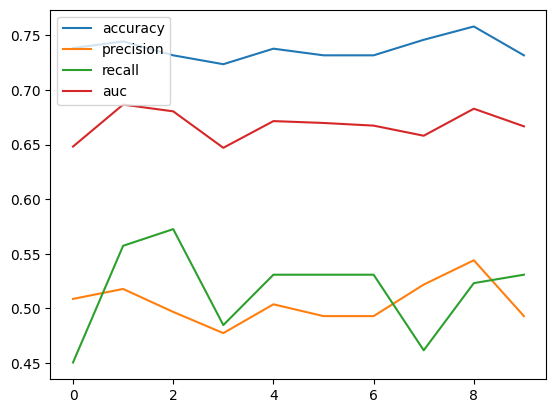

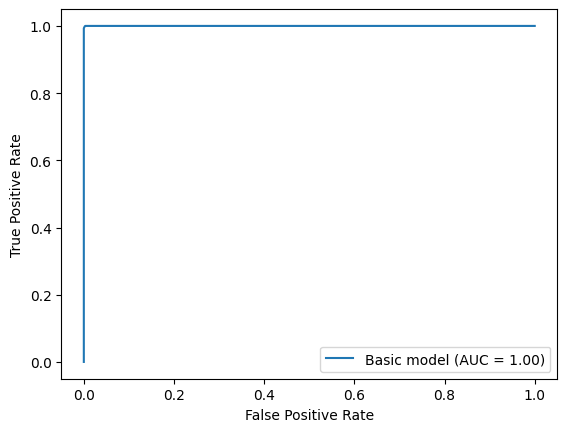

(26, 1026)

In [136]:
# evaluating the model
score_accuracy = cross_val_score(model_basic, X, y, scoring='accuracy', cv=10)
score_precision = cross_val_score(model_basic, X, y, scoring='precision', cv=10)
score_recall = cross_val_score(model_basic, X, y, scoring='recall', cv=10)
score_auc = cross_val_score(model_basic, X, y, scoring='roc_auc', cv=10)

score_accuracy.mean(), score_precision.mean(), score_recall.mean(), score_auc.mean()

# plot graphs
plt.plot(score_accuracy, label="accuracy")
plt.plot(score_precision, label="precision")
plt.plot(score_recall, label="recall")
plt.plot(score_auc, label="auc")
plt.legend(loc="upper left")

# plot AUC
fpr, tpr, thresholds = metrics.roc_curve(y, model_basic.predict_proba(X)[:, 1])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Basic model')
display.plot()
plt.show()

# correctly classifies 4889 out of 4992 samples
if (False):
	print((model.predict_proba(X)[:, 1] == y).sum())

# print the model's depth and number of leaves
model_basic.get_depth(), model_basic.get_n_leaves()

### 2.2 Adjusting max_depth, min_samples_split, and min_samples_leaf

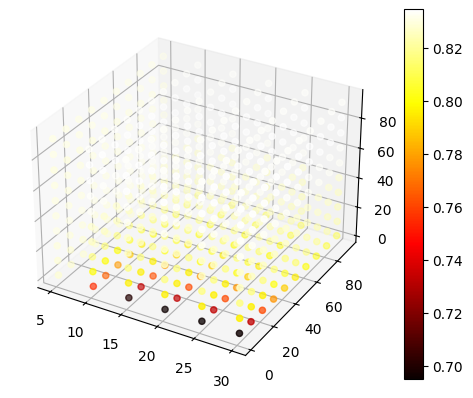

In [144]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(arr_d, arr_ss, arr_sl, c=arr_auc, cmap=plt.hot())
fig.colorbar(img)
plt.show()


In [196]:
# hyperparameter tuning
def tune_parameters() -> list:
	parameters = {'max_depth':np.arange(5, 35, 5), 'min_samples_split':np.arange(10, 110, 10), 'min_samples_leaf': np.arange(10, 110, 10)}
	best_estimators = []
	for creteria in ["accuracy", "recall", "precision", "f1"]:
		clf = GridSearchCV(DecisionTreeClassifier(criterion = 'entropy', random_state=2211), parameters, scoring=creteria, cv=10)
		clf.fit(X, y)
		best_estimators.append(clf.best_estimator_)
	return best_estimators

In [197]:
best_estimators = tune_parameters()

In [ ]:
# save model because it takes 14 minutes to grid search all values


# save
with open('model.pkl','wb') as f:
    pickle.dump(clf,f)

accuracy: 0.7986601032338925
precision: 0.6462178590993901
recall: 0.5287610099823841
auc: 0.8308595355520628
accuracy: 0.7943909859991096
precision: 0.6238216972085608
recall: 0.5663828537874339
auc: 0.8306709781836241
accuracy: 0.7964247431520969
precision: 0.6731177019862142
recall: 0.45115678214914856
auc: 0.833995434947657
accuracy: 0.7943909859991096
precision: 0.6238216972085608
recall: 0.5663828537874339
auc: 0.8306709781836241


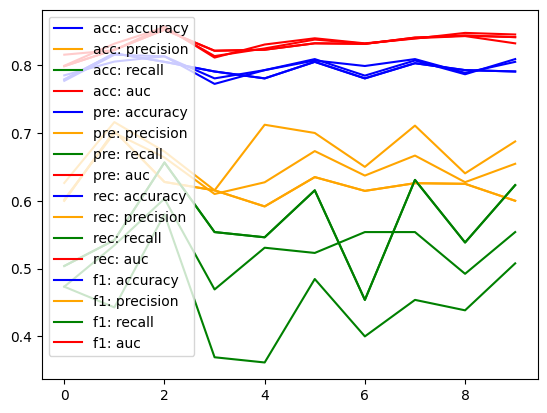

In [200]:
# evaluating the model
def plot_evaluate_model(model, name):
	# compute scores
	score_accuracy = cross_val_score(model, X, y, scoring='accuracy', cv=10)
	score_precision = cross_val_score(model, X, y, scoring='precision', cv=10)
	score_recall = cross_val_score(model, X, y, scoring='recall', cv=10)
	score_auc = cross_val_score(model, X, y, scoring='roc_auc', cv=10)

	print("accuracy:", score_accuracy.mean())
	print("precision:", score_precision.mean())
	print("recall:", score_recall.mean())
	print("auc:", score_auc.mean())

	# plot graphs
	plt.plot(score_accuracy, label=f"{name}: accuracy", color="blue")
	plt.plot(score_precision, label=f"{name}: precision", color="orange")
	plt.plot(score_recall, label=f"{name}: recall", color="green")
	plt.plot(score_auc, label=f"{name}: auc", color="red")
	plt.legend(loc="upper left")

for model, name in zip(best_estimators, ["acc", "pre", "rec", "f1"]):
	plot_evaluate_model(model, name)

TypeError: 'str' object is not callable

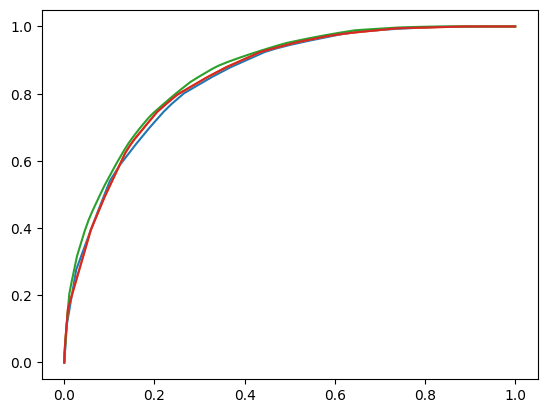

In [205]:
import matplotlib.pyplot as plt
# plot AUC
def plot_auc(model, model_name: str):
	fpr, tpr, thresholds = metrics.roc_curve(y, model.predict_proba(X)[:, 1])
	roc_auc = metrics.auc(fpr, tpr)
	display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
	display.plot()
	plt.show()

fpr1, tpr1, _ = metrics.roc_curve(y, best_estimators[0].predict_proba(X)[:, 1])
plt.plot(fpr1, tpr1, label="Accuracy")
fpr2, tpr2, _ = metrics.roc_curve(y, best_estimators[1].predict_proba(X)[:, 1])
plt.plot(fpr2, tpr2, label="Precision")
fpr3, tpr3, _ = metrics.roc_curve(y, best_estimators[2].predict_proba(X)[:, 1])
plt.plot(fpr3, tpr3, label="Recall")
fpr4, tpr4, _ = metrics.roc_curve(y, best_estimators[3].predict_proba(X)[:, 1])
plt.plot(fpr4, tpr4, label="AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")